In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
import numba as nb
import osqp
from scipy import sparse
from scipy.optimize import minimize

rng_key = jax.random.PRNGKey(0)

## Define functions for visualization

In [2]:
def plot_simulation_result(states):
    """
    Plot the trajectory and orientation of the car given the state history.

    Parameters:
        states (list of np.array): List of states [x, y, theta, v] at each time step.
    """
    x_vals = [state[0] for state in states]
    y_vals = [state[1] for state in states]
    theta_vals = [state[2] for state in states]

    plt.figure(figsize=(6, 6))

    # Generate circle for CBF
    circle = plt.Circle((2, 2), np.sqrt(1), color='grey', fill=True, linestyle='--', linewidth=2, alpha=0.5)
    plt.gca().add_artist(circle)

    # Plot the trajectory
    plt.plot(x_vals, y_vals, '-o', label='Trajectory', markersize=4, alpha=0.5)

    # Plot the orientation at each point
    for i in range(0, len(states), int(len(states)/30)):  # Only plot 20 arrows for visibility
        x, y, theta, _ = states[i]
        dx = 0.1 * np.cos(theta)
        dy = 0.1 * np.sin(theta)
        plt.arrow(x, y, dx, dy, head_width=0.3, head_length=0.3, fc='red', ec='red')

    # plot start and end point
    plt.scatter(3.5, 3.5, s=200, color="green", alpha=0.75, label="init. position")
    plt.scatter(-2.0, -2.0, s=200, color="purple", alpha=0.75, label="target position")

    plt.title('Simulation Result with Car Orientation')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.show()

def get_predicted_trajecotories(current_state, control_sequence):
  predicted_state = [current_state]

  for ctrl in control_sequence:
    next_state = dynamics(predicted_state[-1], ctrl)
    predicted_state.append(next_state.copy())
  return np.array(predicted_state)

def animate_simulation(states, sampled_us=[], optimal_us=None):
    def update(frame, states):
        plt.gca().cla()  # Clear the current axes

        # Set axis limits
        plt.xlim([-3, 4.5])
        plt.ylim([-3, 4.5])

        # Set aspect ratio to be equal, so each cell will be square-shaped
        plt.gca().set_aspect('equal', adjustable='box')

        # Generate circle for CBF
        circle = plt.Circle((2, 2), np.sqrt(1), color='grey', fill=True, linestyle='--', linewidth=2, alpha=0.5)
        plt.gca().add_artist(circle)

        # Plot MPPI trajectories
        if len(sampled_us) > 0:
          # pred_trajs = [get_predicted_trajecotories(states[frame], sampled_us[frame][i]) for i in range(len(sampled_us))]
          num_trajs_plotted = np.minimum(50,  sampled_us[frame].shape[0])  # plot maximum 50 trajs per step
          for idx in range(num_trajs_plotted):
            pred_traj = get_predicted_trajecotories(states[frame], sampled_us[frame][idx])
            x_pos, y_pos = pred_traj[:, 0], pred_traj[:, 1]
            plt.plot(x_pos, y_pos, color="k", alpha=0.1)

        # plot optimal predicted trajectory
        if optimal_us is not None:
          opt_pred_traj = get_predicted_trajecotories(states[frame], optimal_us[frame])
          x_pos, y_pos = opt_pred_traj[:, 0], opt_pred_traj[:, 1]
          plt.plot(x_pos, y_pos, color="orange", alpha=0.8, label="optimized traj.")


        x, y, theta, _ = states[frame]
        dx = 0.1 * np.cos(theta)
        dy = 0.1 * np.sin(theta)

        # Plot the trajectory up to the current frame
        plt.plot([state[0] for state in states[:frame+1]], [state[1] for state in states[:frame+1]], '-o', markersize=4, alpha=0.5)

        # Plot the orientation at the current frame
        plt.arrow(x, y, dx, dy, head_width=0.3, head_length=0.3, fc='red', ec='red')

        plt.scatter(3.5, 3.5, s=200, color="green", alpha=0.75, label="start")
        plt.scatter(-2.0, -2.0, s=200, color="purple", alpha=0.75, label="target")

        plt.title('Simulation Result with Car Orientation')
        plt.xlabel('X Position')
        plt.ylabel('Y Position')
        plt.grid(True)
        plt.legend(loc="upper left")

    fig = plt.figure(figsize=(6, 6))
    anim = FuncAnimation(fig, update, frames=len(states), fargs=(states,), interval=100, blit=False)
    anim.save('simulation.gif', writer='imagemagick')

## Define global parameters

In [3]:
# General parameters
dt = 0.1  # Time step

# Parameters for MPPI
N = 40  # horizon for MPPI
n_samples = 1000  # Number of samples for MPPI
Q = np.diag([3.0, 3.0, 0.0, 10.0])  # Weight for state
QT = Q.copy() * N / 5  # Weight for terminal state
R = np.diag([2.0, 1.0])  # Weight for control
q_ref = np.array([-2.0, -2.0, 0.0, 0.0])  # Reference state
alpha = 0.1  # Tunable parameter for CBF constraint in MPPI, ranged (0, 1]

# Simulation parameters
T = 10  # Total time for simulation
ratio_sim_mppi = 100  # how fast simulator run faster than mppi controller

# Car model marameters
L = 1.0  # Wheelbase length

# CBF-QP safety filter parameters
alpha_qp = 0.75  # Tunable parameter for CBFQP, ranged (0, inf)

# Control shielding parameters
N_shielding = 10  # horizon for predictive filter

## Define bicycle car models

In [4]:
def dynamics(state, control, dt=dt):
    """
    simplified kinematic bicycle car dynamics

    The state of the car is q = (x, y, theta, v), where (x, y) is the position,
    theta is the heading angle, and v is the velocity. The control input is
    the steering angle delta and the acceleration a. The dynamics are given by

      x' = v cos(theta)
      y' = v sin(theta)
      theta' = v tan(delta) / L
      v' = a
    """
    x, y, theta, v = state
    delta, a = control
    dx = v * np.cos(theta)
    dy = v * np.sin(theta)
    dtheta = v * np.tan(delta) / L
    dv = a
    next_state = state + np.array([dx, dy, dtheta, dv]) * dt
    return next_state

@jax.jit
def jax_dynamics(state, control, dt=dt):
    """
    Simplified kinematic bicycle car dynamics with JAX-compatible code.
    """
    x, y, theta, v = state
    delta, a = control
    dx = v * jnp.cos(theta)
    dy = v * jnp.sin(theta)
    dtheta = v * jnp.tan(delta) / L
    dv = a
    next_state = state + jnp.array([dx, dy, dtheta, dv]) * dt
    return next_state


## Define MPPI, CBF-QP, and control shielding[1]

See appendix for derivative of higher-order CBFs for bicycle model

In [5]:
# MPPI
@jax.jit
def jax_mppi(state, U, rng_key, n_samples=n_samples, N=N, q_ref=q_ref, Q=Q, R=R, cbf_cost_weight=1e4, dcbf_alpha=alpha):
    def h_x(x):
      # barrier function
      return jnp.linalg.norm(x[:2] - jnp.array([2.0, 2.0])) - 1

    def scan_fn(carry, u):
        cost, sim_state = carry
        # stage cost
        new_cost = cost + jnp.dot((sim_state - q_ref), jnp.dot(Q, (sim_state - q_ref))) + jnp.dot(u, jnp.dot(R, u))
        new_state = jax_dynamics(sim_state, u)

        # CBF cost
        barrier_value =  h_x(sim_state)
        next_barrier_value =  h_x(new_state)
        cbf_cost = -next_barrier_value + dcbf_alpha * barrier_value
        cbf_cost =  cbf_cost_weight * jnp.clip(cbf_cost, 0.0, np.inf)

        new_cost += cbf_cost
        return (new_cost, new_state), None

    def single_sample_cost(rng_subkey):
        noise = 1.0 * jax.random.normal(rng_subkey, (N, 2))
        noise_scaled = noise * jnp.array([0.3, 0.3])
        u_seq = U + noise_scaled
        # u_seq = u_seq.at[:, 1].set(jnp.clip(u_seq[:, 1], 0, jnp.inf))
        cost_and_state, _ = jax.lax.scan(scan_fn, (0.0, state), u_seq)
        cost = cost_and_state[0]

        # Calculate terminal cost
        terminal_state = cost_and_state[1]
        terminal_cost = jnp.dot((terminal_state - q_ref), jnp.dot(QT, (terminal_state - q_ref)))
        cost += terminal_cost
        return (cost, terminal_state), u_seq

    rng_keys = jax.random.split(rng_key, n_samples)
    all_costs_and_state, all_seqs = jax.vmap(single_sample_cost)(rng_keys)

    # get optimal control input
    final_costs = all_costs_and_state[0]
    temperature = 1.0
    exp_cost =jnp.exp(temperature * (jnp.min(final_costs) - final_costs))
    denom = jnp.sum(exp_cost) + 1e-7
    best_U =  jnp.sum(exp_cost[..., None, None] * all_seqs, axis=0) / denom

    new_U = jnp.roll(best_U, shift=-1, axis=0)
    new_U = new_U.at[-1].set(new_U[-2])
    return best_U[0], new_U, all_seqs

# CBF-QP
def cbfqp_safety_filter(state, u_mppi, alpha=alpha_qp, L=L):
    x, y, theta, v = state
    h = (x - 2)**2 + (y - 2)**2 - 1
    h_dot = 2 * (x - 2) * v * np.cos(theta) + 2 * (y - 2) * v * np.sin(theta)

    # Linear approximation of tan(delta) around delta_0
    delta_0 = float(u_mppi[0])

    # Coefficients for h_ddot
    h_ddot_a = 2 * (x - 2) *np.cos(theta) + 2 * (y - 2) * np.sin(theta)
    h_ddot_delta = -2 * (x - 2) * (v**2) * np.sin(theta) / L + 2 * (y - 2) * (v**2) * np.cos(theta) / L

    # QP matrices
    P = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1e9]])
    q = -np.array([u_mppi[0], u_mppi[1], 0])

    A = np.array([[h_ddot_delta*(1 + np.tan(delta_0) ** 2), h_ddot_a, -1], [1, 0, 0], [0, 1, 0], [0, 0, 1]])
    lb = np.array([
        -h_ddot_delta*np.tan(delta_0) + h_ddot_delta * ((1 + np.tan(delta_0) ** 2) * delta_0) -2*v**2 - h_dot - alpha*h,
        -np.inf,
        -np.inf,
        0
    ])
    ub = np.array([np.inf, np.inf, np.inf, np.inf])

    # Solve with osqp
    m = osqp.OSQP()
    m.setup(P=sparse.csc_matrix(P), q=q, A=sparse.csc_matrix(A), l=lb, u=ub, verbose=False)
    results = m.solve()

    return results.x[:2]  # Return only u[0] and u[1]

# nonlinear predictive filer
def control_shielding(u, q0, N=N_shielding, dt=dt, L=L, alpha=alpha):
    # Parameters
    # L: Wheelbase of the car
    # N: horizon that control shielding taken into account
    # dt: Time discretization step

    # Using Numba to speed up utility functions
    @nb.njit
    def h(x, y):
        return (x - 2)**2 + (y - 2)**2 - 1

    @nb.njit
    def discrete_dynamics(q, delta, a, L):
        x, y, theta, v = q
        next_q = np.zeros(4)
        next_q[0] = x + dt * v * np.cos(theta)
        next_q[1] = y + dt * v * np.sin(theta)
        next_q[2] = theta + dt * (v * np.tan(delta) / L)
        next_q[3] = v + dt * a
        return next_q

    # Objective function
    @nb.njit
    def control_shielding_objective(U, q_init, N, L, alpha):
        J = 0.0
        q = q_init.copy()  # Initial state
        for k in range(N):
            delta, a = U[2*k], U[2*k+1]
            next_q = discrete_dynamics(q, delta, a, L)
            J += min(h(next_q[0], next_q[1]) - 0.1 * h(q[0], q[1]), 0)
            q = next_q
        return -J  # Negate to convert maximization to minimization

    # reshape control input to a 1D sequence for minimize method
    reshaped_u = u[:N, ...].copy()
    reshaped_u =  reshaped_u.reshape(np.prod(reshaped_u.shape))

    # Run optimization, passing the initial state as an argument
    result = minimize(control_shielding_objective, reshaped_u, args=(q0, N, L, alpha), method='BFGS', options={"maxiter": 100})

    # Extract optimized control sequence
    opt_U = result.x.reshape((N, 2))
    return opt_U[0]

## 0. Run closed-loop simulation of MPPI with nonlinear control shielding

This simulation might take some time to complete due to slow control shielding.

/Users/zi-angcao/miniconda3/envs/JAX/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:615: RuntimeWarning: invalid value encountered in divide
  J_transposed[i] = df / dx
/Users/zi-angcao/miniconda3/envs/JAX/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:615: RuntimeWarning: invalid value encountered in divide
  J_transposed[i] = df / dx
/Users/zi-angcao/miniconda3/envs/JAX/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:615: RuntimeWarning: invalid value encountered in divide
  J_transposed[i] = df / dx
/Users/zi-angcao/miniconda3/envs/JAX/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:615: RuntimeWarning: invalid value encountered in divide
  J_transposed[i] = df / dx
/Users/zi-angcao/miniconda3/envs/JAX/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:615: RuntimeWarning: invalid value encountered in divide
  J_transposed[i] = df / dx
/Users/zi-angcao/miniconda3/envs/JAX/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:615: RuntimeWarni

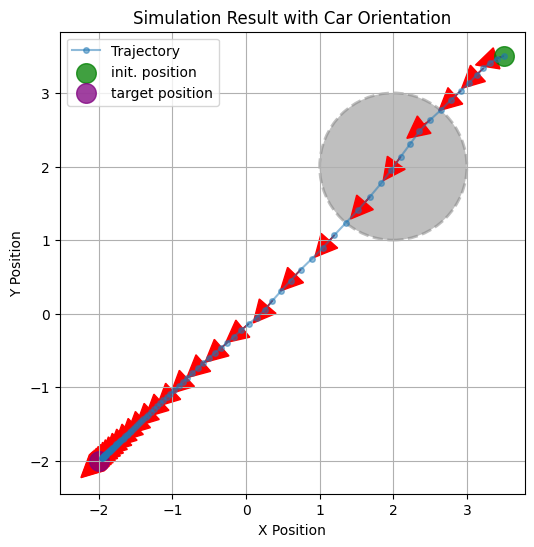

In [6]:
# Initialize state and control
state = np.array([3.5, 3.5, np.random.uniform(-np.pi, np.pi), 1.0])  # [x, y, theta, v]
states = [state]  # `states` is a list containing the states over time
U = np.zeros((N, 2))  # Initial control sequence for MPPI

# Closed-loop simulation
global_U = U.copy()
sim_state = state.copy()
mppi_sampled_us = [np.zeros((n_samples, N, 2))]
global_Us = [global_U.copy()]
for t in np.arange(0, T, dt):
    rng_key, subkey = jax.random.split(rng_key)
    u_mppi_cbf, global_U, sampled_us = jax_mppi(sim_state, global_U, subkey, cbf_cost_weight=0.0)  # Set cbf_cost_weight as zero
    # preprocessing for control shielding
    local_U = np.zeros_like(global_U)
    local_U[0] = u_mppi_cbf
    local_U[1:] = global_U[:-1].copy()
    u_mppi_cbf = control_shielding(u=local_U, q0=sim_state, N=N_shielding, dt=dt, L=L)  # Control shielding
    for i in range(ratio_sim_mppi):
        sim_state = dynamics(sim_state, u_mppi_cbf, dt=dt/ratio_sim_mppi)
    states.append(sim_state)
    mppi_sampled_us.append(sampled_us)
    global_Us.append(global_U.copy())

# Visualize result
states = np.array(states)  # Convert list of states to numpy array for analysis or plotting
plot_simulation_result(states)

## 1. Run closed-loop simulation of MPPI with CBF cost

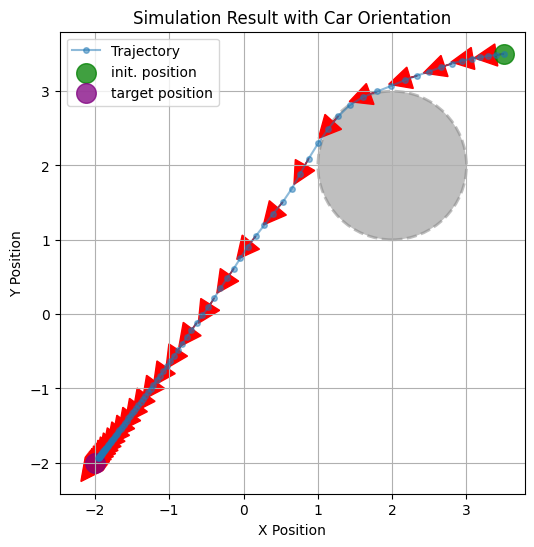

In [7]:
# Initialize state and control
state = np.array([3.5, 3.5, np.random.uniform(-np.pi, np.pi), 1.0])  # [x, y, theta, v]
states = [state]  # `states` is a list containing the states over time
U = np.zeros((N, 2))  # Initial control sequence for MPPI

# Closed-loop simulation
global_U = U.copy()
sim_state = state.copy()
mppi_sampled_us = [np.zeros((n_samples, N, 2))]
global_Us = [global_U.copy()]
for t in np.arange(0, T, dt):
    rng_key, subkey = jax.random.split(rng_key)
    u_mppi_cbf, global_U, sampled_us = jax_mppi(sim_state, global_U, subkey, cbf_cost_weight=1e4)  # Set cbf_cost_weight as a large value
    for i in range(ratio_sim_mppi):
        sim_state = dynamics(sim_state, u_mppi_cbf, dt=dt/ratio_sim_mppi)
    states.append(sim_state)
    mppi_sampled_us.append(sampled_us)
    global_Us.append(global_U.copy())

# Visualize result
states = np.array(states)  # Convert list of states to numpy array for analysis or plotting
plot_simulation_result(states)

## 2. Run closed-loop simulation of MPPI with CBFQP safety filter

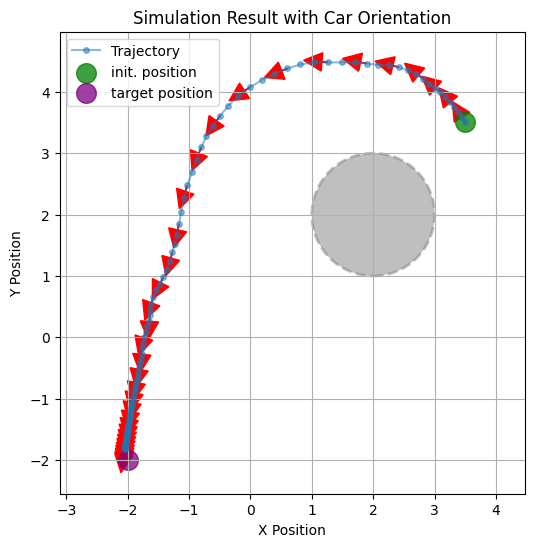

In [8]:
# Initialize state and control
state = np.array([3.5, 3.5, np.random.uniform(-np.pi, np.pi), 1.0])  # [x, y, theta, v]
states = [state]  # `states` is a list containing the states over time
U = np.zeros((N, 2))  # Initial control sequence for MPPI

# Closed-loop simulation
global_U = U.copy()
sim_state = state.copy()
mppi_sampled_us = [np.zeros((n_samples, N, 2))]
global_Us = [global_U.copy()]
for t in np.arange(0, T, dt):
    rng_key, subkey = jax.random.split(rng_key)
    u_mppi_cbf, global_U, sampled_us = jax_mppi(sim_state, global_U, subkey, cbf_cost_weight=0.0)  # Set cbf_cost_weight as zero
    for i in range(ratio_sim_mppi):
        u_mppi_cbf = cbfqp_safety_filter(sim_state, u_mppi_cbf)  # CBF safety filter
        sim_state = dynamics(sim_state, u_mppi_cbf, dt=dt/ratio_sim_mppi)
    states.append(sim_state)
    mppi_sampled_us.append(sampled_us)
    global_Us.append(global_U.copy())

# Visualize result
states = np.array(states)  # Convert list of states to numpy array for analysis or plotting
plot_simulation_result(states)

## Generate animation

GIF saved as `simulation.gif`

MovieWriter imagemagick unavailable; using Pillow instead.


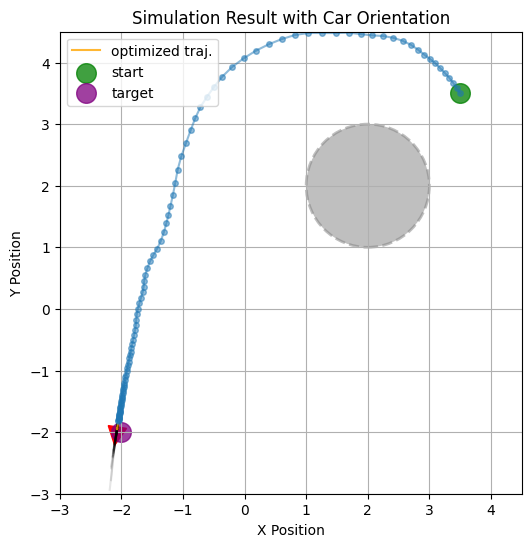

In [9]:
anim = animate_simulation(states, mppi_sampled_us, global_Us)

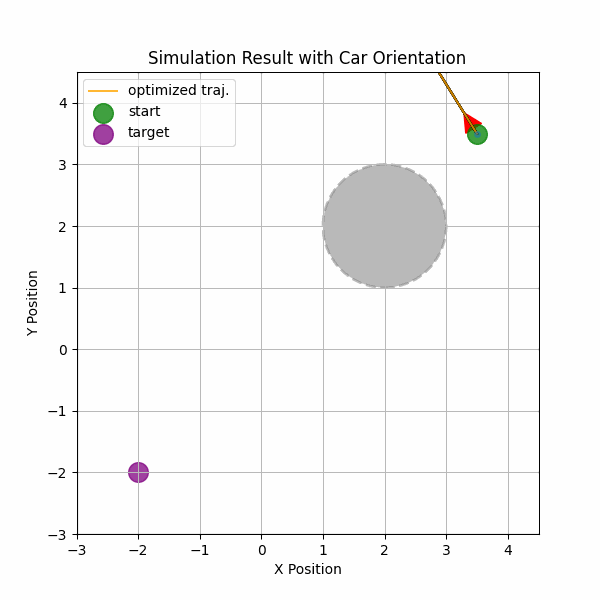

In [10]:
from IPython.display import Image
Image(open('simulation.gif','rb').read())

## Appendix: derivative of control barrier function for bicycle car model


### I. Car model
The state of the car is denoted as $q$ and is given by

\begin{equation}
q = (x, y, \theta, v)
\end{equation}
where:
- $(x, y)$ is the position.
- $\theta$ is the heading angle.
- $v$ is the velocity.

The control input consists of:
- The steering angle $\delta$.
- The acceleration $a$.

The dynamics of the car are described by the following equations:
$$
\begin{align}
    \dot{x} &= v \cos(\theta) \\
    \dot{y} &= v \sin(\theta) \\
    \dot{\theta} &= \frac{v \tan(\delta)}{L} \\
    \dot{v} &= a
\end{align}
$$

### II. Control barrier function
The control barrier function is defined as below, which represents the distance to a circle at (2, 2) with radius 1.
\begin{equation}
h(q) = (x - 2)^2 + (y-2)^2 - 1
\end{equation}

The derivative of $h(q)$ is therefore:
$$
\begin{align}
    \dot{h}(q) &= \frac{dh}{dq}\frac{dq}{dt} \\
    \  &= 2(x-2)\dot{x} + 2(y-2)\dot{y} \\
    \  &= 2(x-2)v \cos(\theta) + 2(y-2)v \sin(\theta)
\end{align}
$$

As shown above, the control input $(\delta, a)$ is not presented in $\dot{h}(q)$. In order to incoporate control input in barrieer constraint, we can differentiate $\dot{h}(q)$ further to expose them.
Given:
$$
\ddot{h} = \frac{\partial \dot{h}}{\partial x} \dot{x} + \frac{\partial \dot{h}}{\partial y} \dot{y} + \frac{\partial \dot{h}}{\partial \theta} \dot{\theta} + \frac{\partial \dot{h}}{\partial v} \dot{v}
$$

Deriving $\dot{h}$ with respect to each state variable:
$$
\begin{align*}
\frac{\partial \dot{h}}{\partial x} &= 2v \cos(\theta) \\
\frac{\partial \dot{h}}{\partial y} &= 2v \sin(\theta) \\
\frac{\partial \dot{h}}{\partial \theta} &= -2(x - 2) v \sin(\theta) + 2(y - 2) v \cos(\theta) \\
\frac{\partial \dot{h}}{\partial v} &= 2(x - 2) \cos(\theta) + 2(y - 2) \sin(\theta)
\end{align*}
$$

Substituting everything into the $\ddot{h}$ expression:
$$
\ddot{h} = 2v^2 [\cos^2(\theta) + \sin^2(\theta)] + \frac{-2(x - 2) v^2 \sin(\theta) + 2(y - 2) v^2 \cos(\theta)}{L}\tan(\delta)+[2(x-2)\cos(\theta)+2(y-2)\sin(\theta)] a
$$

Now, the second derivative $\ddot{h}$ includes the control inputs $\delta$ and $a$.

### III. Linearize $\ddot{h}$ for solving CBF constraints using QP
We further approximate $\tan(\delta)$ through Taylor expansion so that the $\ddot{h}$ is linearized to $\delta$ and can be solved through QP.

The Taylor expansion of a function $f(x)$ about the point $x_0$ is given by:
\begin{equation}
f(x) \approx f(x_0) + f'(x_0)(x - x_0)
\end{equation}

Using the formula:
\begin{equation}
\tan(\delta) \approx \tan(\delta_0) +(1+\tan^2(\delta_0))(\delta - \delta_0)
\end{equation}

With the equations derived so far, we can formulate the CBF problem in a QP fashion with some manipulations. Please refer to `cbfqp_safety_filter(...)` for the implementation. The higher-order CBF constraint is as below.

\begin{equation}
\dot{\bar{h}}(q, u) \ge -\bar{h}(q, u), \\\bar{h}(q, u)=\dot{h}(q, u)+\alpha_{QP}\cdot{h(q)}
\end{equation}

or

\begin{equation}
\ddot{h}(q, u) \ge -\dot{h}(q, u) - \alpha_{QP}\cdot{h}(q)
\end{equation}

## References
1. Shield Model Predictive Path Integral: A Computationally Efficient Robust MPC Approach Using Control Barrier Functions, Ji Yin, et.al. [https://arxiv.org/abs/2302.11719](https://arxiv.org/abs/2302.11719)
